# Analisi Performance Studenti

### Progetto di Programmazione di Applicazioni Data Intensive

*2019/2020*

Realizzato da: **Matteo Lucchi**

*0000830161*

**matteo.lucchi11@studio.unibo.it**

## Descrizione del Problema
* Cerchiamo di predirre lo score ottenuto da uno studente avendo a disposizione diverse informazioni personali.
* Ipotiziamo di disporre già di un dataset contenente le informazioni e gli score.
* Studiamo i dati a nostra disposizione per fare previsioni.

## Librerie Utilizzate

* Numpy: utilizzata per la creazione e la manipolazione di strutture matematiche (arrat n-dimensionali, ...)
* pandas: per il caricamento e la gestione ottimale di dati in formato tabulare.
* matplotlib: necessaria per la creazione di grafici.
* sklearn: indispensabile per il processo di Regressione.

Utilizzo gli alias convenzionali e abilito l'uso di grafici in-line.

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import sklearn

%matplotlib inline

## Caricamento dei Dati

* Utiliziamo un dataset presente su Kaggle e fornito da: http://roycekimmons.com/tools/generated_data/exams
* I dati sono quindi generati da un algoritmo pseudocasuale.
* Scelgo come dimensione del dataset 5000 entità (righe della tabella = studenti)

* La cella seguente si occupa del reperimento del dataset in formato .csv

In [74]:
import os.path
file = "StudentsPerformances.csv";
if not os.path.exists(file):
    print("Missing dataset, retrieve it from:");
    print("http://roycekimmons.com/tools/generated_data/exams");

studentPerformances = pd.read_csv(file);

## Descrizione Features

* `gender` indica il sesso dello studente/studentessa.
* `race/ethnicity` indica il gruppo etnico.
* `parental level of education` titolo di studio conseguito da un genitore.
* `lunch` indica il tipo di pasto abituale.
* `test preparation course` gli studenti possono seguire o meno il corso di preparazione all'esame.
* `reading score` punteggio ottenuto nella prova di comprensione.
* `writing score` punteggio ottenuto nella prova di scrittura.
* `math score` punteggio ottenuto nella prova di matematica.

### Obbiettivo
* L'obbiettivo è quello di stimare lo score ottenuto nella prova di matematica.

* Il procedimento sarebbe equivalente anche per gli altri due score.

Osserviamo alcune informazioni sul dataset:

In [75]:
studentPerformances.info(verbose=False, memory_usage="deep");


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Columns: 8 entries, gender to writing score
dtypes: int64(3), object(5)
memory usage: 1.7 MB


In [76]:
studentPerformances.head()

gender race/ethnicity parental level of education         lunch  \
0    male        group B          associate's degree      standard   
1    male        group D          associate's degree      standard   
2    male        group D                 high school      standard   
3  female        group B           bachelor's degree      standard   
4  female        group E           bachelor's degree  free/reduced   

  test preparation course  math score  reading score  writing score  
0                    none          58             46             42  
1                    none          84             76             75  
2                    none          77             83             77  
3                    none          68             75             75  
4                    none          60             75             73

Dato che nessuna colonna può fungere da identificatore univoco utiliziamo un indice incrementale.

Osseriviamo che delle 8 features **3** sono binarie (`gender`, `lunch`, `test preparation course`), **2** sono categoriche (`race/ethnicity`, `parental level of education`).

Si sceglie quindi di caricarle in memoria come considerando la precedente affermazione

In [77]:
categories = ["gender", "race/ethnicity", "parental level of education", "lunch", "test preparation course"];
performances = pd.read_csv(file, dtype={x:"category" for x in categories});

In [78]:
performances.info(verbose=False, memory_usage="deep");
performances.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Columns: 8 entries, gender to writing score
dtypes: category(5), int64(3)
memory usage: 143.4 KB


gender race/ethnicity parental level of education         lunch  \
0    male        group B          associate's degree      standard   
1    male        group D          associate's degree      standard   
2    male        group D                 high school      standard   
3  female        group B           bachelor's degree      standard   
4  female        group E           bachelor's degree  free/reduced   

  test preparation course  math score  reading score  writing score  
0                    none          58             46             42  
1                    none          84             76             75  
2                    none          77             83             77  
3                    none          68             75             75  
4                    none          60             75             73

Si nota come il consumo di memoria diminuisca da 1.7 MB a 1.1 MB, una riduzione del **35.3%**

Tutte le features sono ritenute *rilevanti*, in caso contrario avrei potuto rimuovere quelle inutili.

Ora che abbiamo chiarito il significato di ogni colonna, per semplificarne l'uso ne abbrevio i nomi

In [79]:
perf = performances.rename(columns={'race/ethnicity': 'ethn', 'parental level of education': 'parent_ed', 'test preparation course': 'prep_course', 'math score': 'math', 'reading score': 'reading', 'writing score': 'writing'})

perf.head()

gender     ethn           parent_ed         lunch prep_course  math  \
0    male  group B  associate's degree      standard        none    58   
1    male  group D  associate's degree      standard        none    84   
2    male  group D         high school      standard        none    77   
3  female  group B   bachelor's degree      standard        none    68   
4  female  group E   bachelor's degree  free/reduced        none    60   

   reading  writing  
0       46       42  
1       76       75  
2       83       77  
3       75       75  
4       75       73

## *Analisi Generale dei Dati*

Mostriamo ora le statistiche principali per fornire conoscenza sul dominio applicativo e capire da quanti elementi sono composte le categorie non binarie.

In [80]:
for x in ["ethn", "parent_ed"]:
    print(x+": "+ str(perf[x].nunique()));

ethn: 5
parent_ed: 6


Osserviamo quindi **5** possibili etnie e **6** possibili livelli di educazione dei genitori.

In [81]:
for x in ["ethn", "parent_ed"]:
    print(x+": " + str(perf[x].cat.categories))

ethn: Index(['group A', 'group B', 'group C', 'group D', 'group E'], dtype='object')
parent_ed: Index(['associate's degree', 'bachelor's degree', 'high school',
       'master's degree', 'some college', 'some high school'],
      dtype='object')


I Gruppi Etnici sono: `A`, `B`, `C`, `D`, `E`.

I Possibili Livelli di Educazione sono: `Associate's Degree`, `Bachelor's Degree`, `High School`, `Master's Degree`, `Some College`, `Some High School`

Concentriamoci ora sulle diverse distribuzioni degli studenti presi in analisi.

In [82]:
labels = 'Female', 'Male'
sizes = perf["gender"].value_counts()
explode = (0,0.05)  # only "explode" the 2nd slice (i.e. 'Hogs')
colors = ['#ff9999', '#66b3ff']

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)

#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.tight_layout()
plt.title("Gender Distribution", bbox={'facecolor':'0.8', 'pad':5}, loc="right")
plt.show()
female, male = sizes
print("Females: " + str(female))
print("Males: " + str(male))

Females: 2548
Males: 2452


Come possiamo vedere dal grafico il dataset è diviso abbastanza equamente tra Studentesse e Studenti.

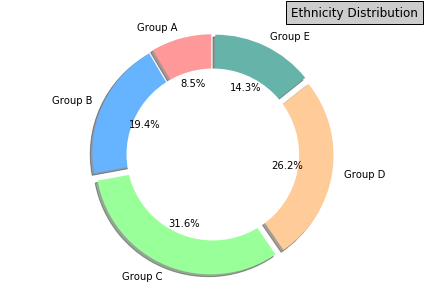

group A     424
group B     972
group C    1581
group D    1309
group E     714
Name: ethn, dtype: int64


In [83]:
labels = 'Group A', 'Group B', 'Group C', 'Group D', 'Group E'
sizes = perf["ethn"].value_counts(sort=False)
explode = (0.05,0.05,0.05,0.05,0.05)  # only "explode" the 2nd slice (i.e. 'Hogs')
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99', '#66b3aa']

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)

#draw circle
centre_circle = plt.Circle((0,0),0.75,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.tight_layout()
plt.title("Ethnicity Distribution", bbox={'facecolor':'0.8', 'pad':5}, loc="right")
plt.show()

print(sizes)

Notiamo una presenza maggiore dei gruppi C, D e B, ed una minore dei gruppi E e A.
Nessun gruppo predomina però sul totale degli Studenti.

In [84]:
perf["parent_ed"].value_counts().plot.barh(orientation="horizontal", color=['#ff9999','#66b3ff','#99ff99','#ffcc99', '#66b3aa', '#ffaa88']);

low_ed = perf[(perf["parent_ed"]=="some high school") | (perf["parent_ed"]=="high school")]
high_ed = perf[(perf["parent_ed"]!="some high school") & (perf["parent_ed"]!="high school")]

diff = [len(low_ed), len(high_ed)]
diff

[1913, 3087]

In [85]:
low_ed = perf[(perf["parent_ed"]=="some high school") | (perf["parent_ed"]=="high school")]
high_ed = perf[(perf["parent_ed"]!="some high school") & (perf["parent_ed"]!="high school")]
diff = [len(low_ed), len(high_ed)]

labels = 'High School Diploma', 'College or Higher'
sizes = diff
explode = (0, 0.05)  # only "explode" the 2nd slice (i.e. 'Hogs')
colors = ['#99ff99','#ffcc99']

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)

#draw circle
centre_circle = plt.Circle((0,0),0.75,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.tight_layout()
plt.title("Parents Level Of Education Distribution", bbox={'facecolor':'0.8', 'pad':5}, loc="right")
plt.show()

print(sizes)

[1913, 3087]


Notiamo che i genitori degli studenti che hanno frequentato il college sono circa il doppio dei genitori che hanno invece il diploma del Liceo.

Osserviamo ora qualche statistica sui risultati degli Studenti.

count    5000.000000
mean       66.805000
std        15.199144
min         0.000000
25%        57.000000
50%        67.000000
75%        78.000000
max       100.000000
Name: math, dtype: float64

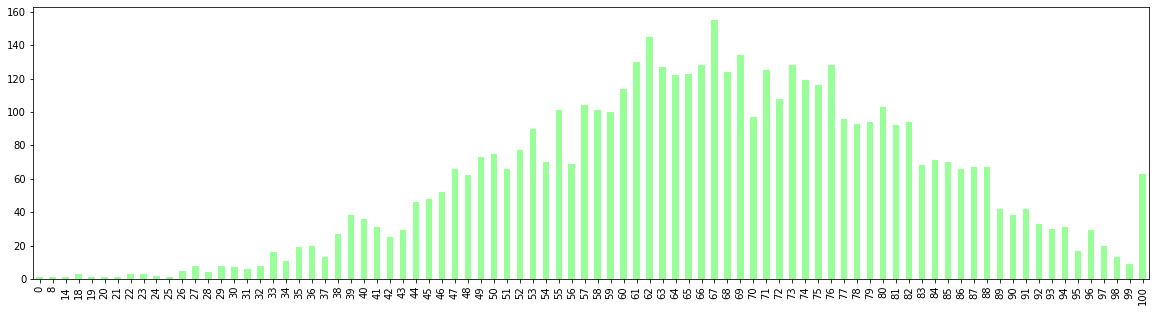

In [86]:
perf["math"].value_counts().sort_index().plot.bar(figsize=(20, 5), color="#99ff99");
perf["math"].describe()

Distribuzione degli score in matematica

In [87]:
perf["reading"].value_counts().sort_index().plot.bar(figsize=(20, 5), color="#66b3ff");
perf["reading"].describe()

count    5000.000000
mean       69.690200
std        14.425514
min        17.000000
25%        60.000000
50%        70.000000
75%        80.000000
max       100.000000
Name: reading, dtype: float64

Distribuzione degli score di comprensione

count    5000.000000
mean       68.584200
std        15.142126
min        10.000000
25%        58.000000
50%        69.000000
75%        79.000000
max       100.000000
Name: writing, dtype: float64

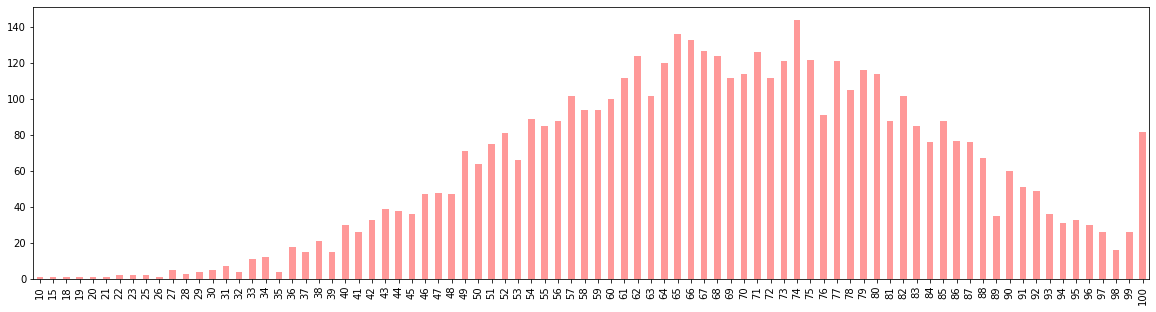

In [88]:
perf["writing"].value_counts().sort_index().plot.bar(figsize=(20, 5), color="#ff9999");
perf["writing"].describe()

Distribuzione degli score di scrittura

Notiamo come le tre distribuzioni abbiamo una forma sostanzialmente a campana, il che indica una distribuzione Gaussiana.

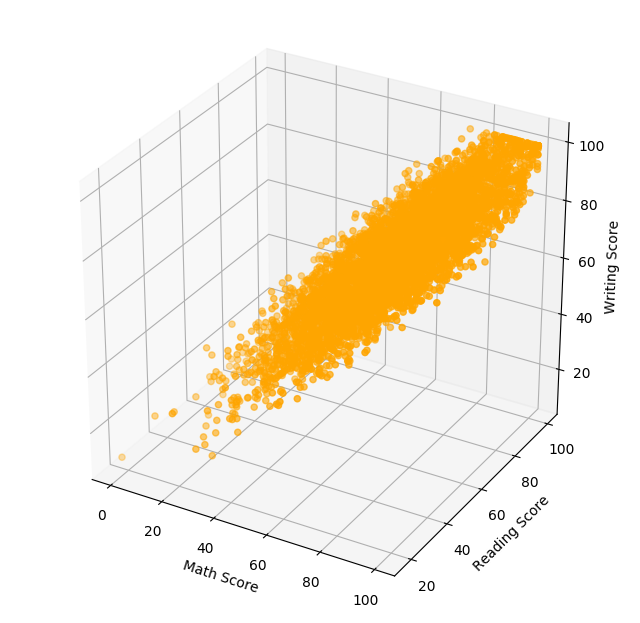

In [89]:
fig = plt.figure(figsize=(8, 8), dpi=100)
ax = fig.add_subplot(111, projection='3d')

ax.scatter(perf["math"], perf["reading"], perf["writing"], c='orange', marker='o')

ax.set_xlabel('Math Score')
ax.set_ylabel('Reading Score')
ax.set_zlabel('Writing Score')

plt.show()

Ci accorgiamo subito che gli Score nei tre diversi esami sono molto simili.

Allo stesso modo la loro deviazione standard è stabile intorno al 15.

Osservando il grafico in 3 dimensioni notiamo come, studenti con buoni risultati in uno dei tre campi tendono ad ottenere buoni risultati anche negli altri due.

### Correlazioni tra Features
- I grafici a dispersione che andremo a mostrare evidenzieranno eventuali correlazioni tra features.

none         3251
completed    1749
Name: prep_course, dtype: int64


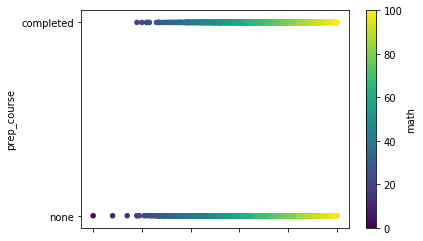

In [90]:
perf.plot.scatter("math", "prep_course", c="math", colormap="viridis");

print(perf["prep_course"].value_counts())

notiamo che di 40 punti in su la distribuzione degli score coincide, mentre i voti più bassi, sotto al 40 sono ottenuti solo dagli studenti che non hanno frequentato il `corso di preparazione`.

standard        3289
free/reduced    1711
Name: lunch, dtype: int64


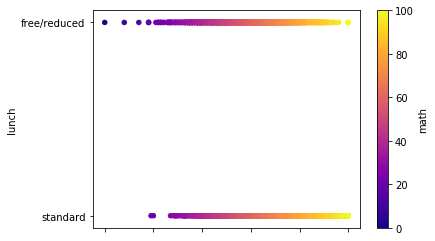

In [91]:
perf.plot.scatter("math", "lunch", c="math", colormap="plasma");
print(perf["lunch"].value_counts())

In modo simile al corso di preparazione notiamo che le distribuzioni si assomigliano al di sopra di una soglia, in questo caso del punteggio 30.

Mentre al di sotto di tale soglia troviamo soltanto gli score di studenti con `pasti` "free/reduced"

female    2548
male      2452
Name: gender, dtype: int64


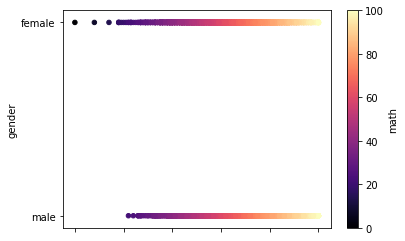

In [92]:
perf.plot.scatter("math", "gender", c="math", colormap="magma");
print(perf["gender"].value_counts())

Notiamo ancora una simile distribuzione, ovvero che la maggior parte degli score sotto al 30 sono ottenuti dalle studentesse, mentre al di sopra del 30 la distribuzione è simile

group C    1581
group D    1309
group B     972
group E     714
group A     424
Name: ethn, dtype: int64


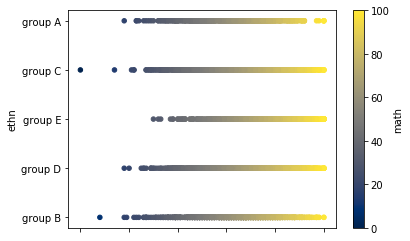

In [93]:
perf.plot.scatter("math", "ethn", c="math", colormap="cividis");
print(perf["ethn"].value_counts())

Il `gruppo A` ha una distribuzione più uniforme rispetto agli altri gruppi.

Al `gruppo C` appartengono gli studenti con i voti più bassi ed il minor numero di studenti che hanno ottenuto il massimo dei voti.

Il `gruppo E` è quello che ha ottenuto i punteggi meno bassi.

Il gruppo di ha una distribuzione abbastanza uniforme, con risultati simili a quelli del `gruppo D`.

Infine il `gruppo B` ha una distribuzione uniforme, con però meno risultati eccellenti e più risultati negativi rispetto agli altri gruppi.

some college          1151
high school           1030
associate's degree    1013
some high school       883
bachelor's degree      559
master's degree        364
Name: parent_ed, dtype: int64


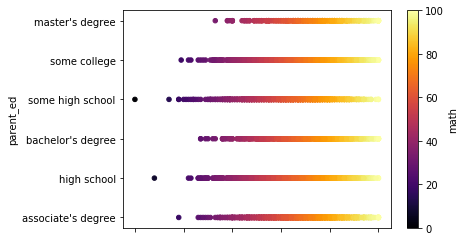

In [94]:
perf.plot.scatter("math", "parent_ed", c="math", colormap="inferno");
print(perf["parent_ed"].value_counts())

Come possiamo notare i risultati peggiori sono stati ottenuti da studenti i cui genitori possiedono i titoli `some college`, `some high school` e `high school`.

Mentre i risultati eccellenti sono maggiormente ottenuti dagli studenti i cui genitori possiedono `master's degree`, `bachelor's degree` e `associate's degree`.

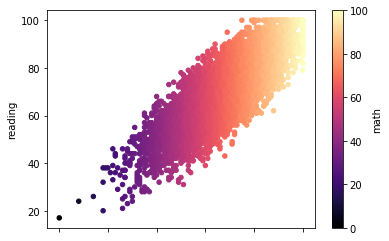

In [95]:
perf.plot.scatter("math", "reading", c="math", colormap="magma");

Come già notato con il grafico in 3D gli score in `matematica` e quelli in `comprensione` sono proporzionali.

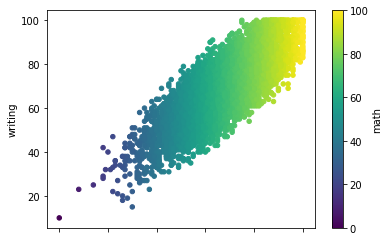

In [96]:
perf.plot.scatter("math", "writing", c="math", colormap="viridis");

Idem per gli score in `scrittura`

## Preparazione dei Dati

Gestiamo eventuali valori nulli

In [97]:
print("Presence of NaN: " + str(perf.isnull().values.any()))
print(perf.isnull().sum())

Presence of NaN: False
gender         0
ethn           0
parent_ed      0
lunch          0
prep_course    0
math           0
reading        0
writing        0
dtype: int64


Essendo i nostri dati generati e non acquisiti dal mondo reale potevamo immaginarci questo risultato.

Selezione delle feature rilevanti ed eliminazione delle ridondanze

In [98]:
for x in perf:
    print(x+": " + str(perf[x].nunique()))

gender: 2
ethn: 5
parent_ed: 6
lunch: 2
prep_course: 2
math: 86
reading: 80
writing: 84


Decido inizialmente di usare tutte le variabili a disposizione.

### Conversione dei Dati

In [99]:
perf.head()

gender     ethn           parent_ed         lunch prep_course  math  \
0    male  group B  associate's degree      standard        none    58   
1    male  group D  associate's degree      standard        none    84   
2    male  group D         high school      standard        none    77   
3  female  group B   bachelor's degree      standard        none    68   
4  female  group E   bachelor's degree  free/reduced        none    60   

   reading  writing  
0       46       42  
1       76       75  
2       83       77  
3       75       75  
4       75       73

Converto i dati testuali in numerici.

In [100]:
perf["ethn"] = perf["ethn"].str.replace(" ", "")
perf["parent_ed"] = perf["parent_ed"].str.replace(" ", "")
perf["parent_ed"] = perf["parent_ed"].str.replace("'", "")
perf["lunch"] = perf["lunch"].str.replace("/", "")

In [101]:
perfcpy = perf.copy(deep=True)
perfcpy.head(10)

gender    ethn         parent_ed        lunch prep_course  math  reading  \
0    male  groupB  associatesdegree     standard        none    58       46   
1    male  groupD  associatesdegree     standard        none    84       76   
2    male  groupD        highschool     standard        none    77       83   
3  female  groupB   bachelorsdegree     standard        none    68       75   
4  female  groupE   bachelorsdegree  freereduced        none    60       75   
5  female  groupD    somehighschool     standard   completed    87       97   
6  female  groupB       somecollege     standard        none    61       69   
7  female  groupE       somecollege     standard        none    75       81   
8  female  groupB   bachelorsdegree     standard        none    76       76   
9  female  groupD    somehighschool  freereduced        none    50       59   

   writing  
0       42  
1       75  
2       77  
3       75  
4       73  
5      100  
6       69  
7       81  
8       81  
9       58

In [102]:
perfcpy["gender"] = perfcpy["gender"].map(dict(male=1, female=2))
perfcpy["ethn"] = perfcpy["ethn"].map(dict(groupA=1, groupB=2, groupC=3, groupD=4, groupE=5))
perfcpy["parent_ed"] = perfcpy["parent_ed"].map(dict(highschool=1, bachelorsdegree=2, somehighschool=3, associatesdegree=4, mastersdegree=5, somecollege=6))
perfcpy["lunch"] = perfcpy["lunch"].map(dict(standard=1, freereduced=2))
perfcpy["prep_course"] = perfcpy["prep_course"].map(dict(none=1, completed=2))

In [103]:
perfcpy.head(10)

gender  ethn  parent_ed  lunch prep_course  math  reading  writing
0      1     2          4      1           1    58       46       42
1      1     4          4      1           1    84       76       75
2      1     4          1      1           1    77       83       77
3      2     2          2      1           1    68       75       75
4      2     5          2      2           1    60       75       73
5      2     4          3      1           2    87       97      100
6      2     2          6      1           1    61       69       69
7      2     5          6      1           1    75       81       81
8      2     2          2      1           1    76       76       81
9      2     4          3      2           1    50       59       58

### Correlazioni - i numeri
Ora che tutte le variabili hanno valore numerico cerco conferma delle correlazioni precedentemente individuate tramite il **coefficiente di correlazione di Pearson**, un indice usato per valutare numericamente il grado di correlazione tra due variabili X e Y.
- Il suo valore è compreso tra -1 e 1
  - valori vicini a 1 indicano correlazione diretta (Y cresce al crescere di X)
  - valori vicini a -1 indicano correlazione inversa (Y descresce al crescere di X)
  - valori vicini a 0 indicano assenza di correlazione

In [104]:
gender = perfcpy["gender"].to_numpy()
ethn = perfcpy["ethn"].to_numpy()
parent_ed = perfcpy["parent_ed"].to_numpy()
lunch = perfcpy["lunch"].to_numpy()
prep_course = perfcpy["prep_course"].to_numpy()
math = perfcpy["math"].to_numpy()
reading = perfcpy["reading"].to_numpy()
writing = perfcpy["writing"].to_numpy()

**math - prep_course**

Osserviamo una scarsa correlazione

In [105]:
np.mean((math-math.mean()) * (prep_course-prep_course.mean())) / (math.std() * prep_course.std())

0.1648780424250109

**math - lunch**

Lieve correlazione

In [106]:
np.mean((math-math.mean()) * (lunch-lunch.mean())) / (math.std() * lunch.std())

-0.36883542501420863

**math - gender**

Scarsa correlazione

In [107]:
np.mean((math-math.mean()) * (gender-gender.mean())) / (math.std() * gender.std())

-0.17032485892445046

**math - ethn**

Scarsa Correlazione

In [108]:
np.mean((math-math.mean()) * (ethn-ethn.mean())) / (math.std() * ethn.std())

0.24200934701462187

**math - parent_ed**

Scarsissima correlazione

In [109]:
np.mean((math-math.mean()) * (parent_ed-parent_ed.mean())) / (math.std() * parent_ed.std())

0.10003174540889578

**math - reading**

Correlazione molto alta

In [110]:
np.mean((math-math.mean()) * (reading-reading.mean())) / (math.std() * reading.std())

0.8166364507697237

**math - writing**

Correlazione molto alta

In [111]:
np.mean((math-math.mean()) * (writing-writing.mean())) / (math.std() * writing.std())

0.8051727867021483

### BINARIZZAZIONE
Convertiamo le variabili categoriche in variabili binarie.

In [112]:
perfcpy = perf.copy(deep=True)
perfcpy.head()

gender    ethn         parent_ed        lunch prep_course  math  reading  \
0    male  groupB  associatesdegree     standard        none    58       46   
1    male  groupD  associatesdegree     standard        none    84       76   
2    male  groupD        highschool     standard        none    77       83   
3  female  groupB   bachelorsdegree     standard        none    68       75   
4  female  groupE   bachelorsdegree  freereduced        none    60       75   

   writing  
0       42  
1       75  
2       77  
3       75  
4       73

In [113]:
perfcpy["male"] = perfcpy["gender"].map(dict(male=1, female=0))
perfcpy["female"] = perfcpy["gender"].map(dict(male=0, female=1))
perfcpy = perfcpy.drop(columns="gender")

perfcpy["groupA"] = perfcpy["ethn"].map(dict(groupA=1, groupB=0, groupC=0, groupD=0, groupE=0))
perfcpy["groupB"] = perfcpy["ethn"].map(dict(groupA=0, groupB=1, groupC=0, groupD=0, groupE=0))
perfcpy["groupC"] = perfcpy["ethn"].map(dict(groupA=0, groupB=0, groupC=1, groupD=0, groupE=0))
perfcpy["groupD"] = perfcpy["ethn"].map(dict(groupA=0, groupB=0, groupC=0, groupD=1, groupE=0))
perfcpy["groupE"] = perfcpy["ethn"].map(dict(groupA=0, groupB=0, groupC=0, groupD=0, groupE=1))
perfcpy = perfcpy.drop(columns="ethn")

perfcpy["highschool"] = perfcpy["parent_ed"].map(dict(highschool=1, bachelorsdegree=0, somehighschool=0, associatesdegree=0, mastersdegree=0, somecollege=0))
perfcpy["bachelorsdegree"] = perfcpy["parent_ed"].map(dict(highschool=0, bachelorsdegree=1, somehighschool=0, associatesdegree=0, mastersdegree=0, somecollege=0))
perfcpy["somehighschool"] = perfcpy["parent_ed"].map(dict(highschool=0, bachelorsdegree=0, somehighschool=1, associatesdegree=0, mastersdegree=0, somecollege=0))
perfcpy["associatesdegree"] = perfcpy["parent_ed"].map(dict(highschool=0, bachelorsdegree=0, somehighschool=0, associatesdegree=1, mastersdegree=0, somecollege=0))
perfcpy["mastersdegree"] = perfcpy["parent_ed"].map(dict(highschool=0, bachelorsdegree=0, somehighschool=0, associatesdegree=0, mastersdegree=1, somecollege=0))
perfcpy["somecollege"] = perfcpy["parent_ed"].map(dict(highschool=0, bachelorsdegree=0, somehighschool=0, associatesdegree=0, mastersdegree=0, somecollege=1))
perfcpy = perfcpy.drop(columns="parent_ed")

perfcpy["lunch_standard"] = perfcpy["lunch"].map(dict(standard=1, freereduced=0))
perfcpy["lunch_freereduced"] = perfcpy["lunch"].map(dict(standard=0, freereduced=1))
perfcpy = perfcpy.drop(columns="lunch")

perfcpy["prep_course_none"] = perfcpy["prep_course"].map(dict(none=1, completed=0))
perfcpy["prep_course_completed"] = perfcpy["prep_course"].map(dict(none=0, completed=1))
perfcpy = perfcpy.drop(columns="prep_course")

In [114]:
perfcpy.head(10)

math  reading  writing male female  groupA  groupB  groupC  groupD  groupE  \
0    58       46       42    1      0       0       1       0       0       0   
1    84       76       75    1      0       0       0       0       1       0   
2    77       83       77    1      0       0       0       0       1       0   
3    68       75       75    0      1       0       1       0       0       0   
4    60       75       73    0      1       0       0       0       0       1   
5    87       97      100    0      1       0       0       0       1       0   
6    61       69       69    0      1       0       1       0       0       0   
7    75       81       81    0      1       0       0       0       0       1   
8    76       76       81    0      1       0       1       0       0       0   
9    50       59       58    0      1       0       0       0       1       0   

   highschool  bachelorsdegree  somehighschool  associatesdegree  \
0           0                0               0                 1   
1           0                0               0                 1   
2           1                0               0                 0   
3           0                1               0                 0   
4           0                1               0                 0   
5           0                0               1                 0   
6           0                0               0                 0   
7           0                0               0                 0   
8           0                1               0                 0   
9           0                0               1                 0   

   mastersdegree  somecollege  lunch_standard  lunch_freereduced  \
0              0            0               1                  0   
1              0            0               1                  0   
2              0            0               1                  0   
3              0            0               1                  0   
4              0            0               0                  1   
5              0            0               1                  0   
6              0            1               1                  0   
7              0            1               1                  0   
8              0            0               1                  0   
9              0            0               0                  1   

  prep_course_none prep_course_completed  
0                1                     0  
1                1                     0  
2                1                     0  
3                1                     0  
4                1                     0  
5                0                     1  
6                1                     0  
7                1                     0  
8                1                     0  
9                1                     0

### NORMALIZZAZIONE
La normalizzazione risolve i problemi dati dal fatto che i valori dei dati delle colonne numeriche potrebbero essere molto distanti l'uno dall'altro il che può portare a situazioni indesiderabili negli algoritmi di regressione.
Decidiamo quindi di normalizzare i dati, traducendo i dati di ciascuna colonna in valori compresi tra 0 e 1.

In [115]:
perfcpy["math"] = (perfcpy["math"] - np.min(perfcpy["math"]))/(np.max(perfcpy["math"]) - np.min(perfcpy["math"]))
perfcpy["reading"] = (perfcpy["reading"] - np.min(perfcpy["reading"]))/(np.max(perfcpy["reading"]) - np.min(perfcpy["reading"]))
perfcpy["writing"] = (perfcpy["writing"] - np.min(perfcpy["writing"]))/(np.max(perfcpy["writing"]) - np.min(perfcpy["writing"]))

In [116]:
perfcpy.head(10)

math   reading   writing male female  groupA  groupB  groupC  groupD  \
0  0.58  0.349398  0.355556    1      0       0       1       0       0   
1  0.84  0.710843  0.722222    1      0       0       0       0       1   
2  0.77  0.795181  0.744444    1      0       0       0       0       1   
3  0.68  0.698795  0.722222    0      1       0       1       0       0   
4  0.60  0.698795  0.700000    0      1       0       0       0       0   
5  0.87  0.963855  1.000000    0      1       0       0       0       1   
6  0.61  0.626506  0.655556    0      1       0       1       0       0   
7  0.75  0.771084  0.788889    0      1       0       0       0       0   
8  0.76  0.710843  0.788889    0      1       0       1       0       0   
9  0.50  0.506024  0.533333    0      1       0       0       0       1   

   groupE  highschool  bachelorsdegree  somehighschool  associatesdegree  \
0       0           0                0               0                 1   
1       0           0                0               0                 1   
2       0           1                0               0                 0   
3       0           0                1               0                 0   
4       1           0                1               0                 0   
5       0           0                0               1                 0   
6       0           0                0               0                 0   
7       1           0                0               0                 0   
8       0           0                1               0                 0   
9       0           0                0               1                 0   

   mastersdegree  somecollege  lunch_standard  lunch_freereduced  \
0              0            0               1                  0   
1              0            0               1                  0   
2              0            0               1                  0   
3              0            0               1                  0   
4              0            0               0                  1   
5              0            0               1                  0   
6              0            1               1                  0   
7              0            1               1                  0   
8              0            0               1                  0   
9              0            0               0                  1   

  prep_course_none prep_course_completed  
0                1                     0  
1                1                     0  
2                1                     0  
3                1                     0  
4                1                     0  
5                0                     1  
6                1                     0  
7                1                     0  
8                1                     0  
9                1                     0

### Holdout - Divisione tra training e validation set
Divido il dataset su cui lavoriamo in due sottoinsiemi:
* `training` set utilizzato per addestrare i modelli.
* `validation` set utilizzato per verificare i risultati dei modelli.

Estraggo dal datframe:
* la serie `y` con i valori reali della variabile `math` da prevedere.
* il frame `X` con i valori di tutte le altre variabili.


In [117]:
y = perfcpy["math"]
X = perfcpy.drop(columns="math")

Decido di suddividere `X` e `y` in `train` e `validation` sets con un rapporto 7/3

Il parametro `random_state` indica il seed della divisione casuale, in modo da poter essere replicabile.

In [118]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = \
    train_test_split(X, y, test_size=0.3, random_state=66)

### Metriche d'errore
Mi preparo ad individuare *errore relativo*, *mean squared error* e *coefficiente di determinazione 𝑅2*.
* *mean squared error*: misura l'errore che compie il modello durante la predizione di dati sconosciuti.
* *errore relativo*: indica l'errore del modello in percentuale rispetto al valore reale, molto utile per i confronti tra modelli diversi addestrati sugli stessi dati.
* *coefficiente 𝑅2*: misura quanto il modello cattura la variabilità presente dei dati. Deve essere il più possibile vicino a 1.

from sklearn.metrics import mean_squared_error, r2_score

In [119]:
from sklearn.metrics import mean_squared_error, r2_score

Creo un dataframe sul quale annotare i risultati dei vari modelli.

In [120]:
results_benchmark = pd.DataFrame(columns=['Tipo','Errore_Quadratico_Medio','Errore_Relativo','Coefficiente_R2'])

Funzione per la visualizzazione dei risultati di un modello dato il frame X e la serie y.

In [121]:
def show_scores(X, y, model):
    preds = model.predict(X)
    print("   Mean squared error: {:.5}".format(mean_squared_error(y, preds)))
    print("       Relative error: {:.5%}".format(np.mean(np.abs((y - preds) / y))))
    print("R-squared coefficient: {:.5}".format(r2_score(y, preds)))

### REGRESSIONE LINEARE
La regressione lineare è un modello semplice ma spesso abbastanza efficace per ricavare modelli di predizione su variabili continue.
Per essere precisi la nostra variabile `math` è un valore discreto da `0` a `100`, il che, teoricamente, richiederebbe un approccio con algoritmi di classificazione.
Dato però l'alto numero di classi ed il significato intrinseco del problema decido di affrontarlo come un problema di predizione di una variabile continua, la quale sarà poi approssimata ad un valore discreto (lo `score` effettivo).

In [122]:
from sklearn.linear_model import LinearRegression

In [123]:
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [124]:
show_scores(X_val, y_val, lin_model)

   Mean squared error: 0.0029247
       Relative error: 6.98273%
R-squared coefficient: 0.86977


In [125]:
new_row = {'Tipo':'Regressione Lineare', 'Errore_Quadratico_Medio':0.00292, 'Errore_Relativo':6.9827, 'Coefficiente_R2':0.86977}
#append row to the dataframe
results_benchmark = results_benchmark.append(new_row, ignore_index=True)

results_benchmark.head()

Tipo  Errore_Quadratico_Medio  Errore_Relativo  \
0  Regressione Lineare                  0.00292           6.9827   

   Coefficiente_R2  
0          0.86977

I risultati ottenuti sono buoni.
Il valore di 𝑅2 del **86.9%** quindi il modello si adatta bene ai dati.
L'errore relativo ed quello quadratico medio sono molto bassi, per cui otteniamo già una buona predizione con la regressione lineare.
Decidiamo però di utilizzare altre tecniche per osservare e confrontare i possibili risultati.

Prendiamo **coefficienti angolari** utilizzati dal modello e creiamo una serie che associ ad ogni coefficente il nome della feature.

In [126]:
pd.Series(lin_model.coef_, index=perfcpy.columns[1:])

reading                  2.211637e-01
writing                  6.087012e-01
male                    -1.557178e+12
female                  -1.557178e+12
groupA                  -1.326668e+12
groupB                  -1.326668e+12
groupC                  -1.326668e+12
groupD                  -1.326668e+12
groupE                  -1.326668e+12
highschool              -1.297543e+10
bachelorsdegree         -1.297543e+10
somehighschool          -1.297543e+10
associatesdegree        -1.297543e+10
mastersdegree           -1.297543e+10
somecollege             -1.297543e+10
lunch_standard          -3.282884e+08
lunch_freereduced       -3.282884e+08
prep_course_none         2.060570e+10
prep_course_completed    2.060570e+10
dtype: float64

Il **coefficiente angolare** rappresenta la variazione subita in media dalla variabile da predirre `math` per effetto di un aumento unitario della variabile in questione.

### Grid search
L'accuratezza del modello può dipendere fortemente dagli **iperparametri**.
Per individuare gli iperparametri che massimizzano l'accuratezza utilizzo un dizionario in cui inserisco la griglia di parametri che devo trovare, e lo do' in pasto alla grid search.
Il modello finale sarà accessibile all'attributo `gs_best_estimator_`, mentre con l'attributo `_best_params` ottengo i valori migliori degli iperparametri.

Creo una funzione che, preso un modello e una griglia contenente i parametri, calcola l'accuratezza del modello applicando l'algoritmo di grid search e **cross validation**.

In [127]:
from sklearn.model_selection import GridSearchCV

In [128]:
def grid_search(model, grid):
    gs = GridSearchCV(model, grid, cv=kf)
    #...
    gs.fit(X_train, y_train)
    print("Iperparametri migliori:")
    print(gs.best_params_)
    show_scores(X_val, y_val, gs)
    
    return gs;

### Cross Validation K Fold
Tecnica con la quale:
* Dividiamo i dati causalmente, con seed, in **k** gruppi ognuno dei quali funge da **validation set** per un modello che ha come **training set** l'unione degli altri **k-1** gruppi.
* Questo procedimento viene ripetuto *k* volte per ogni gruppo (K Fold).
* Otteniamo un dizionario con un vettore per ciascuna misura estratta, con un valore per ogni fold.
* Come **accuratezza** del modello prendo la media e deviazione standard degli score dei fold.

In [129]:
from sklearn.model_selection import KFold, cross_validate

In [130]:
kf = KFold(8, shuffle=True, random_state=66)

### Regressione Polinomiale
* La regressione polinomiale è una generalizzazione di quella lineare in cui la funzione utilizza termini di grado superiore al primo.
* Standardizzo i dati per uniformarne i valori di scale diverse.
* Per comodità uso una **Pipeline**.

In [131]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

In [132]:
poly_model = Pipeline([
    ("poly",   PolynomialFeatures(include_bias=False)), #default-> 2nd grado
    ("linreg", LinearRegression())
])
grid_poly = {
    "poly__degree": range(2, 6), #dal secondo al sesto grado#
}

In [133]:
gs = grid_search(poly_model, grid_poly)

Iperparametri migliori:
{'poly__degree': 2}
   Mean squared error: 0.0029548
       Relative error: 6.99709%
R-squared coefficient: 0.86843


In [134]:
new_row = {'Tipo':"Regressione Polinomiale", 'Errore_Quadratico_Medio':0.002954, 'Errore_Relativo':6.99709, 'Coefficiente_R2':0.86843}
#append row to the dataframe
results_benchmark = results_benchmark.append(new_row, ignore_index=True)

In [135]:
results_benchmark.head()

Tipo  Errore_Quadratico_Medio  Errore_Relativo  \
0      Regressione Lineare                 0.002920          6.98270   
1  Regressione Polinomiale                 0.002954          6.99709   

   Coefficiente_R2  
0          0.86977  
1          0.86843

Osserviamo risultati quasi identici alla regressione lineare ma con tempi astronomicamente superiori.

### Regressione Ridge
* Per eseguire la regressione ridge creiamo un modello `Ridge`.
- $\alpha$ è l'iperparametro che controlla il peso della regolarizzazione.

In [136]:
from sklearn.linear_model import Ridge

In [137]:
ridge_model = Pipeline([
    ("poly",   PolynomialFeatures(include_bias=False)),
    ("scale",  StandardScaler()),
    ("linreg", Ridge())
])
grid_ridge = {
    "poly__degree": range(2, 5), #dal 2 al quinto grado
    "linreg__alpha": [0.1, 1, 2, 3, 4], #provo i valori di alpha
}

In [138]:
gs = grid_search(ridge_model, grid_ridge)

Iperparametri migliori:
{'linreg__alpha': 4, 'poly__degree': 2}
   Mean squared error: 0.0029455
       Relative error: 6.99220%
R-squared coefficient: 0.86884


In [139]:
new_row = {'Tipo':"Regressione Ridge", 'Errore_Quadratico_Medio':0.00294, 'Errore_Relativo':6.99220, 'Coefficiente_R2':0.86884}
#append row to the dataframe
results_benchmark = results_benchmark.append(new_row, ignore_index=True)

In [140]:
results_benchmark.head()

Tipo  Errore_Quadratico_Medio  Errore_Relativo  \
0      Regressione Lineare                 0.002920          6.98270   
1  Regressione Polinomiale                 0.002954          6.99709   
2        Regressione Ridge                 0.002940          6.99220   

   Coefficiente_R2  
0          0.86977  
1          0.86843  
2          0.86884

Anche la regressione con regolarizzazione Ridge ci restituisce risultati simili

### Regressione Lasso
* Con la regressione Lasso addestro un modello ignorando(ponendo a 0) le variabili meno rilevanti per la predizione.
* $\alpha$ ha lo stesso ruolo che nella regolarizzazione Ridge.

In [141]:
from sklearn.linear_model import Lasso

In [142]:
lasso_model = Pipeline([
    ("scale", StandardScaler()),
    ("regr", Lasso())
])
grid_lasso = {
    "regr__alpha": [0.1, 1, 2, 3, 4, 10] #valori di alpha
}

In [143]:
gs = grid_search(lasso_model, grid_lasso)

Iperparametri migliori:
{'regr__alpha': 0.1}
   Mean squared error: 0.017051
       Relative error: 18.01450%
R-squared coefficient: 0.24077


In [144]:
new_row = {'Tipo':"Regressione Lasso", 'Errore_Quadratico_Medio':0.01705, 'Errore_Relativo':18.0145, 'Coefficiente_R2':0.24077}
#append row to the dataframe
results_benchmark = results_benchmark.append(new_row, ignore_index=True)

In [145]:
lasso = pd.Series(gs.best_estimator_.named_steps["regr"].coef_, X.columns).sort_values()
lasso

highschool              -0.00000
lunch_freereduced       -0.00000
lunch_standard           0.00000
somecollege              0.00000
mastersdegree            0.00000
associatesdegree         0.00000
somehighschool          -0.00000
bachelorsdegree          0.00000
prep_course_none        -0.00000
prep_course_completed    0.00000
groupD                   0.00000
groupC                  -0.00000
groupB                  -0.00000
groupA                  -0.00000
female                  -0.00000
male                     0.00000
writing                  0.00000
groupE                   0.00000
reading                  0.02471
dtype: float64

In [146]:
results_benchmark.head()

Tipo  Errore_Quadratico_Medio  Errore_Relativo  \
0      Regressione Lineare                 0.002920          6.98270   
1  Regressione Polinomiale                 0.002954          6.99709   
2        Regressione Ridge                 0.002940          6.99220   
3        Regressione Lasso                 0.017050         18.01450   

   Coefficiente_R2  
0          0.86977  
1          0.86843  
2          0.86884  
3          0.24077

Nonostante siano stati azzerati tutte le variabili meno che una i risultati ottenuti con la regolarizzazione Lasso sono per ora i peggiori ottenuti.

### Regressione Elastic Net 
* Combiniamo regolarizzazioni Ridge e la Lasso

In [147]:
from sklearn.linear_model import ElasticNet

In [148]:
elastic_model = Pipeline([
    ("scale",  StandardScaler()),
    ("regr", ElasticNet())
])
grid_elastic = {
    "regr__alpha": [0.1, 1, 10], #valori di alpha
    "regr__l1_ratio": [0.1, 0.25, 0.5] #percentuale di uso di ridge/lasso
}

In [149]:
gs = grid_search(elastic_model, grid_elastic)

Iperparametri migliori:
{'regr__alpha': 0.1, 'regr__l1_ratio': 0.1}
   Mean squared error: 0.0036455
       Relative error: 8.06374%
R-squared coefficient: 0.83767


In [151]:
new_row = {'Tipo':"Regressione Elastic Net", 'Errore_Quadratico_Medio':0.00364, 'Errore_Relativo':8.06374, 'Coefficiente_R2':0.83767}
#append row to the dataframe
results_benchmark = results_benchmark.append(new_row, ignore_index=True)

In [168]:
results_benchmark.head()

Tipo  Errore_Quadratico_Medio  Errore_Relativo  \
0      Regressione Lineare                 0.002920          6.98270   
1  Regressione Polinomiale                 0.002954          6.99709   
2        Regressione Ridge                 0.002940          6.99220   
3        Regressione Lasso                 0.017050         18.01450   
4  Regressione Elastic Net                 0.003640          8.06374   

   Coefficiente_R2  
0          0.86977  
1          0.86843  
2          0.86884  
3          0.24077  
4          0.83767

Otteniamo risultati migliori della regressione Lasso(ratio = 0.1) ma comunque inferiori a quelli ottenuti con regressione lineare e polinomiale.

### Regressione con funzioni Kernel
* Le funzioni Kernel mi permettono di ottenere modelli ad alta dimensionalità senza dover creare nuove variabili.

In [153]:
from sklearn.kernel_ridge import KernelRidge

In [154]:
kernel_model = Pipeline([
    ("scale", StandardScaler()),
    ("regr",  KernelRidge(kernel="poly"))
])
grid_kernel = {
    "regr__degree": range(2, 11),
    "regr__alpha": [0.01, 0.1, 1, 10],
}

In [155]:
gs = grid_search(kernel_model, grid_kernel)

Iperparametri migliori:
{'regr__alpha': 1, 'regr__degree': 2}
   Mean squared error: 0.0029389
       Relative error: 6.97807%
R-squared coefficient: 0.86914


In [171]:
new_row = {'Tipo':"Regressione Kernel", 'Errore_Quadratico_Medio':0.002938, 'Errore_Relativo':6.97807, 'Coefficiente_R2':0.86914}
#append row to the dataframe
results_benchmark = results_benchmark.append(new_row, ignore_index=True)

In [172]:
results_benchmark.head(10)

Tipo  Errore_Quadratico_Medio  Errore_Relativo  \
0      Regressione Lineare                 0.002920          6.98270   
1  Regressione Polinomiale                 0.002954          6.99709   
2        Regressione Ridge                 0.002940          6.99220   
3        Regressione Lasso                 0.017050         18.01450   
4  Regressione Elastic Net                 0.003640          8.06374   
5       Regressione Kernel                 0.002938          6.97807   

   Coefficiente_R2  
0          0.86977  
1          0.86843  
2          0.86884  
3          0.24077  
4          0.83767  
5          0.86914

La regressione con funzioni Kernel ha ottenuto ottimi risultati, ottenendo l'*Errore Relativo* minore tra tutti i modelli, e con *Errore Quadratico Medio* e *Coefficiente R2* simili alla regressione lineare.

### Valutazione dei modelli migliori
* Valuto con più attenzione i modelli che ho individuato come migliori.

In [173]:
results_benchmark.sort_values(by=['Errore_Quadratico_Medio', 'Errore_Relativo', 'Coefficiente_R2'], ascending=[True, True, False])

Tipo  Errore_Quadratico_Medio  Errore_Relativo  \
0      Regressione Lineare                 0.002920          6.98270   
5       Regressione Kernel                 0.002938          6.97807   
2        Regressione Ridge                 0.002940          6.99220   
1  Regressione Polinomiale                 0.002954          6.99709   
4  Regressione Elastic Net                 0.003640          8.06374   
3        Regressione Lasso                 0.017050         18.01450   

   Coefficiente_R2  
0          0.86977  
5          0.86914  
2          0.86884  
1          0.86843  
4          0.83767  
3          0.24077

* I modelli di **Regressione Lineare** e **Regressione con funzione Kernel " _poly_ "** hanno dato i risultati migliori.

In [174]:
linear = Pipeline([
    ("scale",  StandardScaler(with_mean=False)),
    ("linreg", LinearRegression())
])
linear.fit(X_train, y_train)

kernel = Pipeline([
    ("scale", StandardScaler()),
    ("regr",  KernelRidge(alpha=1, kernel="poly", degree=2))
])
kernel.fit(X_train, y_train);

Visualizziamo i risultati ottenuti dai due modelli

In [175]:
print("Linear model Train")
show_scores(X_train, y_train, linear)
print("--------------------------------")
print("Linear model Val")
show_scores(X_val, y_val, linear)
print("================================")
print("Kernel model Train")
show_scores(X_train, y_train, kernel)
print("--------------------------------")
print("Kernel model Val")
show_scores(X_val, y_val, kernel)


Linear model Train
   Mean squared error: 0.0029081
       Relative error: inf%
R-squared coefficient: 0.87557
--------------------------------
Linear model Val
   Mean squared error: 0.0029296
       Relative error: 6.99742%
R-squared coefficient: 0.86955
Kernel model Train
   Mean squared error: 0.0028313
       Relative error: inf%
R-squared coefficient: 0.87885
--------------------------------
Kernel model Val
   Mean squared error: 0.0029389
       Relative error: 6.97807%
R-squared coefficient: 0.86914


I due risultati sono quasi uguali.

Cerco l'*intervallo di confidenza predittivo* con **confidenza** del 95%

In [176]:
def differenza_tra_modelli(error1, error2):
    z = 1.96 #confidenza 95%, visto a lezione
    varianza = (((1 - error1) * error1) / len(y_val)) + (((1 - error2) * error2) / len(y_val))
    d_min = abs(error1 - error2) - z * (pow(varianza, 0.5)) #radice
    d_max = abs(error1 - error2) + z * (pow(varianza, 0.5))
    print("Valore minimo: {}\nValore massimo: {}\n".format(d_min, d_max))

Calcoliamo la **differenza** tra i due modelli.

In [177]:
error_linear = 1 - r2_score(y_val, linear.predict(X_val))

error_kernel = 1 - r2_score(y_val, kernel.predict(X_val))

differenza_tra_modelli(error_linear, error_kernel)

Valore minimo: -0.02370935504119295
Valore massimo: 0.02453168396722435



Con lo 0 appartenente all'intervallo abbiamo una differenza non statisticamente significativa.

Seppur per pochi decimali il modello di **Regressione Lineare** ha ottenuto risultati migliori, per cui lo individuo come modello definitivo.

### Interpretazione della conoscenza appresa dal modello
* Studiamo i coefficienti della Regressione Lineare.

In [178]:
coefs = pd.Series(linear.named_steps["linreg"].coef_)
coefs_orded = coefs
coefs_orded.sort_values()

3    -1.875655e+12
2    -1.875655e+12
6    -1.719768e+11
7    -1.601815e+11
5    -1.465580e+11
8    -1.279026e+11
18   -1.111634e+11
17   -1.111634e+11
4    -1.028576e+11
14   -8.455858e+10
12   -8.064767e+10
9    -8.064767e+10
11   -7.644880e+10
10   -6.293661e+10
13   -5.175911e+10
0     3.818771e-02
1     1.028303e-01
16    3.311940e+11
15    3.311940e+11
dtype: float64

I valori negativi sono molto più presenti rispetto a quelli positivi
probabilmente sono più le features che infuenzano l'aumento dello score in matematica.


In [179]:
coefs = pd.Series((linear.named_steps["linreg"].coef_).flat[0:19], X.columns).sort_values()
coefs

female                  -1.875655e+12
male                    -1.875655e+12
groupC                  -1.719768e+11
groupD                  -1.601815e+11
groupB                  -1.465580e+11
groupE                  -1.279026e+11
prep_course_completed   -1.111634e+11
prep_course_none        -1.111634e+11
groupA                  -1.028576e+11
somecollege             -8.455858e+10
associatesdegree        -8.064767e+10
highschool              -8.064767e+10
somehighschool          -7.644880e+10
bachelorsdegree         -6.293661e+10
mastersdegree           -5.175911e+10
reading                  3.818771e-02
writing                  1.028303e-01
lunch_freereduced        3.311940e+11
lunch_standard           3.311940e+11
dtype: float64

Osservo che le feature più influenti sono `female`, `male` `lunch_freereduced`, `lunch_standard`.

In [180]:
results_benchmark.head(1)

Tipo  Errore_Quadratico_Medio  Errore_Relativo  \
0  Regressione Lineare                  0.00292           6.9827   

   Coefficiente_R2  
0          0.86977

Il modello ha ottenuto una buona accuratezza: **86.9%**

In [181]:
y_preds = linear.predict(X_val)
y_val1 = pd.DataFrame(y_val.values, columns=['real_math'])
preds1 = pd.DataFrame(y_preds.round(2), columns=['estimated_math'])
ynew = pd.concat([y_val1, preds1], axis=1)
ynew

real_math  estimated_math
0          0.84            0.80
1          0.63            0.70
2          0.55            0.60
3          0.85            0.88
4          0.72            0.69
...         ...             ...
1495       0.77            0.79
1496       0.61            0.64
1497       0.59            0.57
1498       0.49            0.55
1499       0.71            0.74

[1500 rows x 2 columns]